<a href="https://colab.research.google.com/github/plmontecillo/CS-180-Project/blob/main/CS180Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Data Collection and Processing

Historical traffic data in the City of Manila for May 31 to June 6, 2023 was collected from tomtom.com and transcribed into a dataset.

This data consists of 7 days worth of hourly traffic data (168 rows) consisting of 3 features:

1.   Live speed (kilometers/hour) - Formula is km-driven over travel time. The travel time and km-driven are calculated for each directed road segment (DSEG) within the city circle (s.a.) on an hourly basis.
2.   Usual time per 10km (seconds) - Typical travel time per 10km based on TomTom historic data (from 2022). Converted from minutes and seconds format.
3.   Live time per 10km (seconds) - Real-time measurement of traffic in the city. Shows the average time it would currently take to travel 10 km. Converted from minutes and seconds format.

(Descriptions summarized from https://www.tomtom.com/traffic-index/about/)

The weather data for the City of Manila during the same time period was also collected and transcribed from timeanddate.com. However, this data was only available for for every third hour, and some rows were missing. To circumvent this, the data for the hour that is recorded is taken as the data for the previous and next hours. For the first hour, data was taken from the last recording of the previous day (May 30, 2023). And as for the hours with missing data, the last available weather data was used.

This data consists of 7 days worth of weather data (168 rows) consisting of 
7 features:

1.   Temperature (degrees Celsius) - Temperature taken in the area.
2.   Weather - A short description of the weather (e.g. "Thunderstorms.").
3.   Wind (kilometers/hour) - Wind speed measured in the area.
4.   Wind direction (degrees) - A 0 degree wind is defined as a wind that blows directly north to south, and other directions are defined by how much they are rotated counterclockwise from the 0 degree wind.
5.   Humidity (percent) - This is relative humidity, a measure of the current amount of water vapor in the air compared to how much can exist at the current temperature.
6.   Barometer (millibar) - A measure of atmospheric pressure in the area.
7.   Visibility (kilometers) - How far an object can be clearly discerned.

For this project, we are concerned with these features: Difference of Live time per 10km and Usual Time per 10km (a derived quantity, which we are trying to predict), temperature, wind, humidity. barometer, and visibility.

In [ ]:
import pandas as pd

# read data from provided csv file
df = pd.read_csv("/content/180_project_training_data.csv")

# create new row using lambda function to assign row values
df['Difference between live time and usual time'] = df.apply(lambda row: row["Live time per 10 km (s)"] - row["Usual time per 10 km (s)"] , axis = 1)

# drop unnecessary axes
df = df.drop(["Usual time per 10 km (s)", "Live time per 10 km (s)", "Unnamed: 0", "Unnamed: 1", "Live speed (km/h)", "Weather", "Wind direction (°)"], axis = 1)

# scale data values, split data into X (every column except difference between live and usual time) and y (difference between live and usual time columns) dataframes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
X_train = pd.DataFrame(df).iloc[:, :-1]
y_train = pd.DataFrame(df).iloc[:, -1]

# read data from provided csv file (this time to create the test dataset)
df1 = pd.read_csv("/content/180_project_testing_data.csv")

# create new row using lambda function to assign row values
df1['Difference between live time and usual time'] = df1.apply(lambda row: row["Live time per 10 km (s)"] - row["Usual time per 10 km (s)"] , axis = 1)

# drop unnecessary axes
df1 = df1.drop(["Usual time per 10 km (s)", "Live time per 10 km (s)", "Unnamed: 0", "Unnamed: 1", "Live speed (km/h)", "Weather", "Wind direction (°)"], axis = 1)

# scale data values, split data into X (every column except difference between live and usual time) and y (difference between live and usual time columns) dataframes
df1 = scaler.fit_transform(df)
X_test = pd.DataFrame(df1).iloc[:, :-1]
y_test = pd.DataFrame(df1).iloc[:, -1]

# Part II: Training and Testing Model

To start, we will create a linear regression model based on the above training data.

In [ ]:
# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

degrees = list(range(1, 10))
scores = []

for i in degrees:
  regress = PolynomialFeatures(i) # polynomial regression
  # transform the training data
  poly_features = regress.fit_transform(X_train)

  # linear regressor 
  poly_reg = LinearRegression()

  # fit the polynomial model into the regressor
  poly_reg.fit(poly_features, y_train) 

  # predict training data
  y_predicted = poly_reg.predict(poly_features)

  # regression score of the model
  score = poly_reg.score(poly_features, y_train)
  scores.append(score)

# Part III: Results

Text(0, 0.5, 'regression score')

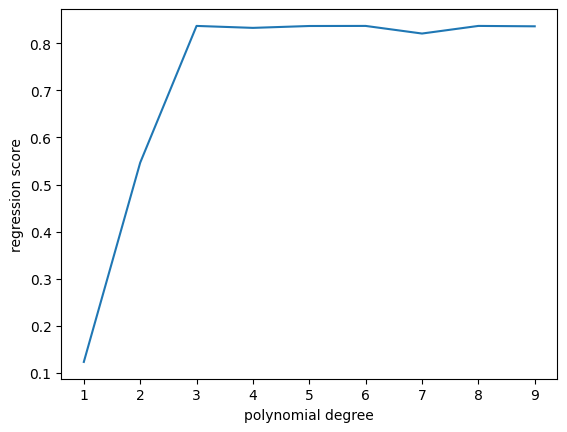

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(degrees, scores)
ax.set_xlabel("polynomial degree")
ax.set_ylabel("regression score")

The figure above shows a plot of the polynomial degrees tried in the model against their corresponding regression scores. As shown in the figure, the regression score sharply plateaus at around 0.83 with a polynomial degree of 3 and barely moves from this score at higher degrees. With this observation, we find that the best polynomial degree to use for the model is 3.

As seen in the regression score, there is a relationship between weather features, and the time lost in traffic. This could be due to weather conditions causing people to drive slower, such as slowing down due to low visibility on the road. 

Our model can help warn people about time lost to traffic in bad weather and plan accordingly, or be used to identify road infrastructure that needs to be adjusted for extreme weather conditions.